<a href="https://colab.research.google.com/github/uday96/EVA4-TSAI/blob/master/S12/EVA4_S12_A_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount and Fetch Data

Original tiny-imagenet-200.zip file was remodified to combine the original train & val images and split 70% - 30% into new_train and new_test

script: **python data/prepare_tiny-imagenet-200.py**

In [14]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%reload_ext autoreload
%autoreload 2

Mounted at /content/gdrive


In [15]:
import zipfile

path_to_zip_file = "/content/gdrive/My Drive/EVA4-Workspace/data/tiny-imagenet-200.zip"
directory_to_extract_to = '/content/data'
print("Extracting zip file: %s" % path_to_zip_file)
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall(directory_to_extract_to)
print("Extracted at: %s" % directory_to_extract_to)

Extracting zip file: /content/gdrive/My Drive/EVA4-Workspace/data/tiny-imagenet-200.zip
Extracted at: /content/data


## Imports and Initialization

Import required modules

In [0]:
# !pip install albumentations==0.4.5

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau

from data.data_engine import DataEngine
from config import ModelConfig
from models.resnet import ResNet18
from train import train
from test import test
from results import plot_images, plot_graph
from utils import *
from gradcam.visualize import VisualizeCam

## Model Configuration and Set Seed

View model configuration and set the seed

In [4]:
# View model config
args = ModelConfig()
args.print_config()
print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 256,
  'dropout': 0,
  'epochs': 15,
  'l1_decay': 0,
  'l2_decay': 0.005,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1,
  'test_data_path': '/content/data/tiny-imagenet-200/new_test',
  'train_data_path': '/content/data/tiny-imagenet-200/new_train'}

CUDA Available


## Data Loading and Visualization

Preprocess and load the tiny-imagenet-200 dataset. Visualise the dataset.

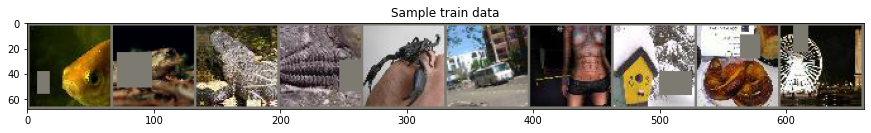

In [5]:
data = DataEngine(args)
data.show_samples()

## Model

Create model and display model summary

In [6]:
device = which_device()
model = ResNet18(num_classes=200).to(device)
show_model_summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

## Training and Testing

Train the model and evaluate it

In [7]:
epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=args.momentum)
scheduler = OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(data.train_loader),
                       epochs=epochs, div_factor=10, final_div_factor=10,
                       pct_start=10/epochs)

test_losses, train_losses, test_accs, train_accs = [], [], [], []
misclassified_imgs, correct_imgs = [], []
lr_trend = []
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses,
           test_accs, misclassified_imgs, correct_imgs, False)

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.002000)


L2_loss=463.498 Loss=6.66350 Batch_id=300 Accuracy=4.89: 100%|██████████| 301/301 [05:04<00:00,  1.01s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 4.3491, Accuracy: 2882/33000 (8.73%)

EPOCH: 2 (LR: 0.002441)


L2_loss=461.415 Loss=6.20977 Batch_id=300 Accuracy=11.39: 100%|██████████| 301/301 [05:05<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 3.9805, Accuracy: 4559/33000 (13.82%)

EPOCH: 3 (LR: 0.003720)


L2_loss=459.152 Loss=5.69592 Batch_id=300 Accuracy=17.42: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 3.6355, Accuracy: 6140/33000 (18.61%)

EPOCH: 4 (LR: 0.005712)


L2_loss=456.587 Loss=5.57533 Batch_id=300 Accuracy=22.44: 100%|██████████| 301/301 [05:05<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 4.2271, Accuracy: 4629/33000 (14.03%)

EPOCH: 5 (LR: 0.008222)


L2_loss=453.861 Loss=5.50864 Batch_id=300 Accuracy=26.57: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 3.6662, Accuracy: 6775/33000 (20.53%)

EPOCH: 6 (LR: 0.011005)


L2_loss=450.878 Loss=5.17947 Batch_id=300 Accuracy=30.53: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 3.1861, Accuracy: 8942/33000 (27.10%)

EPOCH: 7 (LR: 0.013787)


L2_loss=447.611 Loss=5.26496 Batch_id=300 Accuracy=33.91: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.9982, Accuracy: 9936/33000 (30.11%)

EPOCH: 8 (LR: 0.016295)


L2_loss=444.273 Loss=4.83304 Batch_id=300 Accuracy=36.82: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.8458, Accuracy: 11159/33000 (33.82%)

EPOCH: 9 (LR: 0.018286)


L2_loss=440.811 Loss=4.47391 Batch_id=300 Accuracy=39.31: 100%|██████████| 301/301 [05:07<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.8576, Accuracy: 11142/33000 (33.76%)

EPOCH: 10 (LR: 0.019562)


L2_loss=437.316 Loss=4.60719 Batch_id=300 Accuracy=41.65: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.7556, Accuracy: 11720/33000 (35.52%)

EPOCH: 11 (LR: 0.020000)


L2_loss=433.833 Loss=4.45116 Batch_id=300 Accuracy=43.71: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.7684, Accuracy: 11833/33000 (35.86%)

EPOCH: 12 (LR: 0.019877)


L2_loss=430.322 Loss=4.57897 Batch_id=300 Accuracy=45.88: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.7525, Accuracy: 12455/33000 (37.74%)

EPOCH: 13 (LR: 0.019514)


L2_loss=426.949 Loss=4.59221 Batch_id=300 Accuracy=47.53: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.7771, Accuracy: 11836/33000 (35.87%)

EPOCH: 14 (LR: 0.018919)


L2_loss=423.569 Loss=4.14876 Batch_id=300 Accuracy=49.57: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.9259, Accuracy: 11579/33000 (35.09%)

EPOCH: 15 (LR: 0.018106)


L2_loss=420.238 Loss=4.09979 Batch_id=300 Accuracy=51.45: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.6001, Accuracy: 12815/33000 (38.83%)

EPOCH: 16 (LR: 0.017097)


L2_loss=416.972 Loss=3.99168 Batch_id=300 Accuracy=53.15: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.5261, Accuracy: 13631/33000 (41.31%)

EPOCH: 17 (LR: 0.015915)


L2_loss=413.801 Loss=3.97400 Batch_id=300 Accuracy=54.72: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.4132, Accuracy: 14077/33000 (42.66%)

EPOCH: 18 (LR: 0.014590)


L2_loss=410.751 Loss=3.70878 Batch_id=300 Accuracy=56.28: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.4438, Accuracy: 14131/33000 (42.82%)

EPOCH: 19 (LR: 0.013154)


L2_loss=407.829 Loss=3.68341 Batch_id=300 Accuracy=58.02: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.3469, Accuracy: 14862/33000 (45.04%)

EPOCH: 20 (LR: 0.011644)


L2_loss=405.067 Loss=3.62358 Batch_id=300 Accuracy=59.49: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.2047, Accuracy: 15682/33000 (47.52%)

EPOCH: 21 (LR: 0.010095)


L2_loss=402.375 Loss=3.58690 Batch_id=300 Accuracy=61.35: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.1649, Accuracy: 15790/33000 (47.85%)

EPOCH: 22 (LR: 0.008546)


L2_loss=399.850 Loss=3.31099 Batch_id=300 Accuracy=63.38: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.0602, Accuracy: 16717/33000 (50.66%)

EPOCH: 23 (LR: 0.007036)


L2_loss=397.516 Loss=3.33935 Batch_id=300 Accuracy=65.72: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.0176, Accuracy: 17282/33000 (52.37%)

EPOCH: 24 (LR: 0.005601)


L2_loss=395.380 Loss=3.36116 Batch_id=300 Accuracy=67.54: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.0066, Accuracy: 17155/33000 (51.98%)

EPOCH: 25 (LR: 0.004277)


L2_loss=393.529 Loss=3.25843 Batch_id=300 Accuracy=70.28: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.8863, Accuracy: 17986/33000 (54.50%)

EPOCH: 26 (LR: 0.003096)


L2_loss=391.993 Loss=3.14880 Batch_id=300 Accuracy=73.27: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.8687, Accuracy: 18184/33000 (55.10%)

EPOCH: 27 (LR: 0.002088)


L2_loss=390.815 Loss=2.87525 Batch_id=300 Accuracy=75.90: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.7735, Accuracy: 18844/33000 (57.10%)

EPOCH: 28 (LR: 0.001277)


L2_loss=390.039 Loss=2.76731 Batch_id=300 Accuracy=78.38: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.7283, Accuracy: 19111/33000 (57.91%)

EPOCH: 29 (LR: 0.000683)


L2_loss=389.600 Loss=2.75494 Batch_id=300 Accuracy=80.33: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.6985, Accuracy: 19351/33000 (58.64%)

EPOCH: 30 (LR: 0.000321)


L2_loss=389.370 Loss=2.68176 Batch_id=300 Accuracy=81.35: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]


Test set: Average loss: 1.6893, Accuracy: 19385/33000 (58.74%)



In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=args.momentum)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1,
                              verbose=True, min_lr=1e-5)

misclassified_imgs, correct_imgs = [], []
epochs = 10
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1+30} (LR: {lr_trend[-1]:0.6f})")
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs)
      test(model, device, data.test_loader, criterion, data.classes, test_losses,
           test_accs, misclassified_imgs, correct_imgs, epoch==epochs-1)
      scheduler.step(test_losses[-1])

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 31 (LR: 0.000500)


L2_loss=389.152 Loss=2.69688 Batch_id=300 Accuracy=81.81: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.6996, Accuracy: 19344/33000 (58.62%)

EPOCH: 32 (LR: 0.000500)


L2_loss=388.920 Loss=2.66552 Batch_id=300 Accuracy=81.86: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.6929, Accuracy: 19367/33000 (58.69%)

EPOCH: 33 (LR: 0.000500)


L2_loss=388.691 Loss=2.67040 Batch_id=300 Accuracy=82.23: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.6995, Accuracy: 19326/33000 (58.56%)

EPOCH: 34 (LR: 0.000500)


L2_loss=388.461 Loss=2.58813 Batch_id=300 Accuracy=82.31: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.6956, Accuracy: 19358/33000 (58.66%)

Epoch     4: reducing learning rate of group 0 to 2.5000e-04.
EPOCH: 35 (LR: 0.000250)


L2_loss=388.339 Loss=2.54440 Batch_id=300 Accuracy=82.92: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.6933, Accuracy: 19411/33000 (58.82%)

EPOCH: 36 (LR: 0.000250)


L2_loss=388.221 Loss=2.49066 Batch_id=300 Accuracy=83.12: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.6940, Accuracy: 19384/33000 (58.74%)

Epoch     6: reducing learning rate of group 0 to 1.2500e-04.
EPOCH: 37 (LR: 0.000125)


L2_loss=388.159 Loss=2.67146 Batch_id=300 Accuracy=83.51: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.6922, Accuracy: 19376/33000 (58.72%)

EPOCH: 38 (LR: 0.000125)


L2_loss=388.101 Loss=2.63340 Batch_id=300 Accuracy=83.52: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.6906, Accuracy: 19385/33000 (58.74%)

EPOCH: 39 (LR: 0.000125)


L2_loss=388.042 Loss=2.64308 Batch_id=300 Accuracy=83.44: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.6901, Accuracy: 19435/33000 (58.89%)

EPOCH: 40 (LR: 0.000125)


L2_loss=387.984 Loss=2.60399 Batch_id=300 Accuracy=83.74: 100%|██████████| 301/301 [05:06<00:00,  1.02s/it]


Test set: Average loss: 1.6914, Accuracy: 19414/33000 (58.83%)



## Plot Learning Rate Schedule

Plot the change in learning rate vs epochs

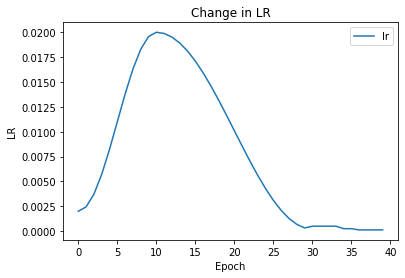

In [9]:
plt_data = {
    "lr": lr_trend,
}
plot_graph(plt_data, "LR")

## Plot Validation Loss

Plot the change in validation loss vs epochs

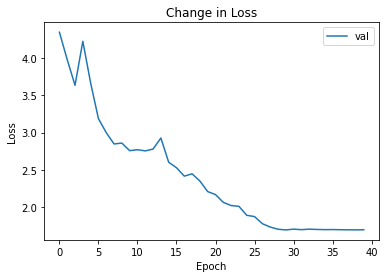

In [10]:
plt_data = {
    "val": test_losses,
}
plot_graph(plt_data, "Loss")

## Plot Validation Accuracy

Plot the change in validation accracy vs epochs

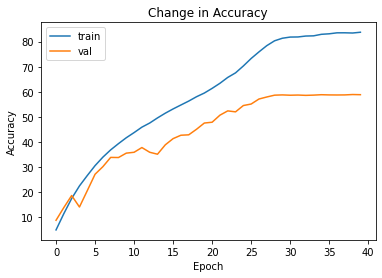

In [11]:
plt_data = {
    "train": train_accs,
    "val": test_accs
}
plot_graph(plt_data, "Accuracy")

## Visualize GradCAM

Use GradCAM to understand where the network is looking at while prediction

In [0]:
target_layers = ["layer1", "layer2", "layer3", "layer4"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

### GradCAM for incorrectly classified images

Layer wise visualization of GradCAM for misclassified images

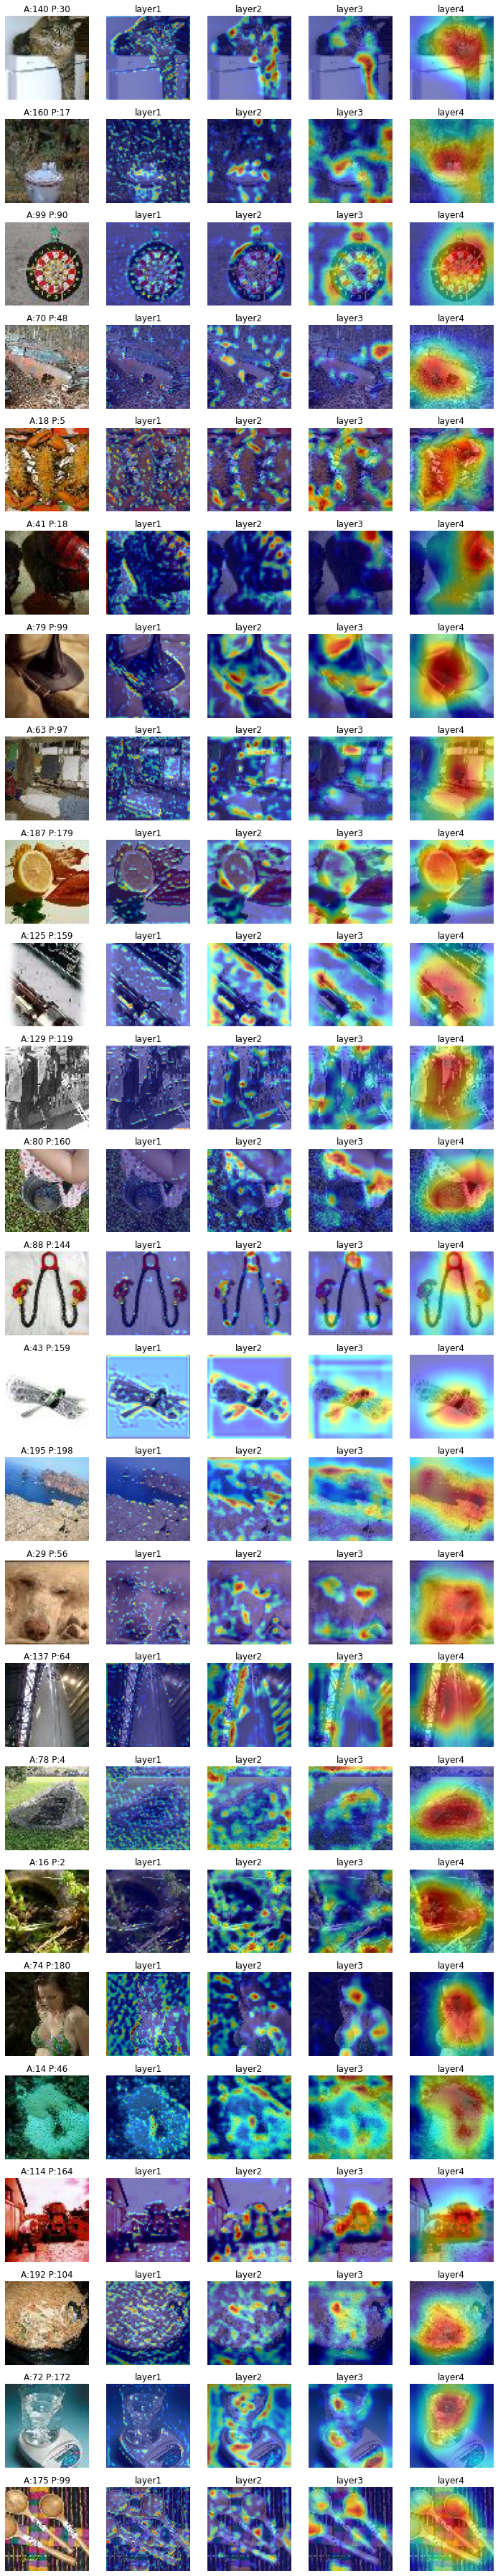

In [13]:
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect", per_image=False)